In [1]:
%matplotlib inline

import numpy as np
import torch
import glob, os, json
import pandas as pd
import h5py

from zennit.attribution import Gradient
from zennit.composites import EpsilonPlus, LayerMapComposite
from zennit.rules import Epsilon, Pass
from zennit.types import Convolution, Activation, AvgPool, Linear
from zennit.types import BatchNorm
from zennit.canonizers import SequentialMergeBatchNorm

from kymatio.numpy import Scattering1D
from examod.utils import normalize_audio
from examod.relevance_cal import relevance_cal
from scipy.stats import kurtosis

import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/home/changhongw/code/miniconda3/envs/examod/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get class map from the csv file
data_dir = '/home/changhongw/datasets/SOL-0.9HQ-PMT/'
df = pd.read_csv(data_dir + 'SOL-0.9HQ-PMT_meta.csv')
classes = df[['modulation technique', 'label']
            ].value_counts().index.to_list()
class_map = dict([x for x in sorted(classes, key=lambda x: x[1])])
             
# class abbrevation map
with open(data_dir + 'class_abbrevation.json', 'r') as f:
    class_abbrv = json.load(f)

In [3]:
# scattering1d config
kwargs = {
    'shape': 2**18,
    'J': 13,
    'T': 2**13,
    'Q': (8, 2)}

## meta for visualization

In [4]:
scat1d = Scattering1D(**kwargs)
meta = scat1d.meta()
sr = 44100
freq_min = 32

# carrier center frequencies condition >= freq_min
freq_cnd = meta['xi'][:, 0] * sr >= freq_min

# indices for scat coefficient to extract 
idx_S1 = np.where(np.logical_and(meta['order'] == 1, freq_cnd))[0]  # order 1
idx_S2 = np.where(np.logical_and(meta['order'] == 2, freq_cnd))[0] # order 2
idx_S1S2 = np.where(np.logical_and(meta['order'] != 0, freq_cnd))[0] # order 1 and 2

In [5]:
xi1s = np.array([sr * psi['xi'] for psi in scat1d.psi1_f])
xi2s = np.array([sr * psi['xi'] for psi in scat1d.psi2_f])

sigma1s = [sr * psi['sigma'] for psi in scat1d.psi1_f]
sigma2s = [sr * psi['sigma'] for psi in scat1d.psi2_f]

mid_xi1s = np.sqrt(xi1s[1:] * xi1s[:-1])  # center for two valuess in a log scale
mid_xi2s = np.sqrt(xi2s[1:] * xi2s[:-1])
x_coords = np.array([sr//2] + list(mid_xi2s) + [xi2s[-1]-sigma2s[-1]])
y_coords = np.array([sr//2] + list(mid_xi1s) + [xi1s[-1]-sigma1s[-1]])

x_coords = np.hstack((x_coords, x_coords[-1] / 2))

## LRP rules

In [6]:
# relevance calculate
model = torch.load('results/cnn_trained_s1s2.pt').eval()
canonizer = SequentialMergeBatchNorm()

In [7]:
# single rule, i.e. Epsilon rule for all layers
single_Epsilon = LayerMapComposite(
    layer_map=[
        (Activation, Pass()),  # pass activations
        (AvgPool, Epsilon(epsilon=1e-6)),  # normalize relevance for any AvgPool
        (Convolution, Epsilon(epsilon=1e-6)),  # any convolutional layer
        (Linear, Epsilon(epsilon=1e-6)),  # dense Linear
        (BatchNorm, Pass()),  # pass BatchNorm 
    ],
    canonizers=[canonizer] # canonizer network
)

In [8]:
rule_types = {'single_Epsilon':single_Epsilon,
    # EpsilonPlus: composite rule, i.e. Epsilon rule for convolutional layers and z_+ rule for dense layers
    'composite_EpsilonPlus': EpsilonPlus(canonizers=[canonizer]),
    }

## Local maps

In [9]:
# log-normalize scattering coefficients
mu = torch.tensor(np.load('SOL-0.9HQ-PMT/scat1d/stats/mu_S1S2.npy'))
c = torch.tensor([1e-1])

In [10]:
# extract scattering coefficients for each file
def input_per_file(test_example):
    data = torch.from_numpy(np.load(test_example))
    data = torch.log1p(data / (c[None, :, None] * mu[None, :, None] + 1e-8))

    input = data.squeeze().mean(-1)
    input_S2 = input[len(idx_S1):]

    # convert into list representation
    Sx2 = [{'coef': input_S2[k], 'n': meta['n'][idx_S2[k],:].astype(int)} for k in range(input_S2.shape[-1])]
    input_feature = np.zeros((len(xi1s), 1+len(xi2s))) * np.nan

    input_feature[:len(idx_S1), -1] = input[:len(idx_S1)]

    for path in Sx2:
        n1 = path['n'][0]
        xi1 = xi1s[n1]
        n2 = path['n'][1]
        xi2 = xi2s[n2]
        if xi1 * sr >= freq_min:
            input_feature[n1, n2] = path['coef'] # / (xi1*xi2)

    # truth class
    class_ = os.path.split(test_example)[1].split('-')[1]
    class_list = [key if class_abbrv[key]==class_ else None for key in class_abbrv]
    class_name = list(filter(None, class_list))[0]
    class_activate = [1 if class_name in key else 0 for key in class_map]
    target = torch.tensor(class_activate)

    name = os.path.split(test_example)[1]
    if 'min' in name.split('-')[2] or 'maj' in name.split('-')[2]:
        note = name.split('-')[3]
    else:
        note = name.split('-')[2]

    return data, input_feature, class_name, target, note


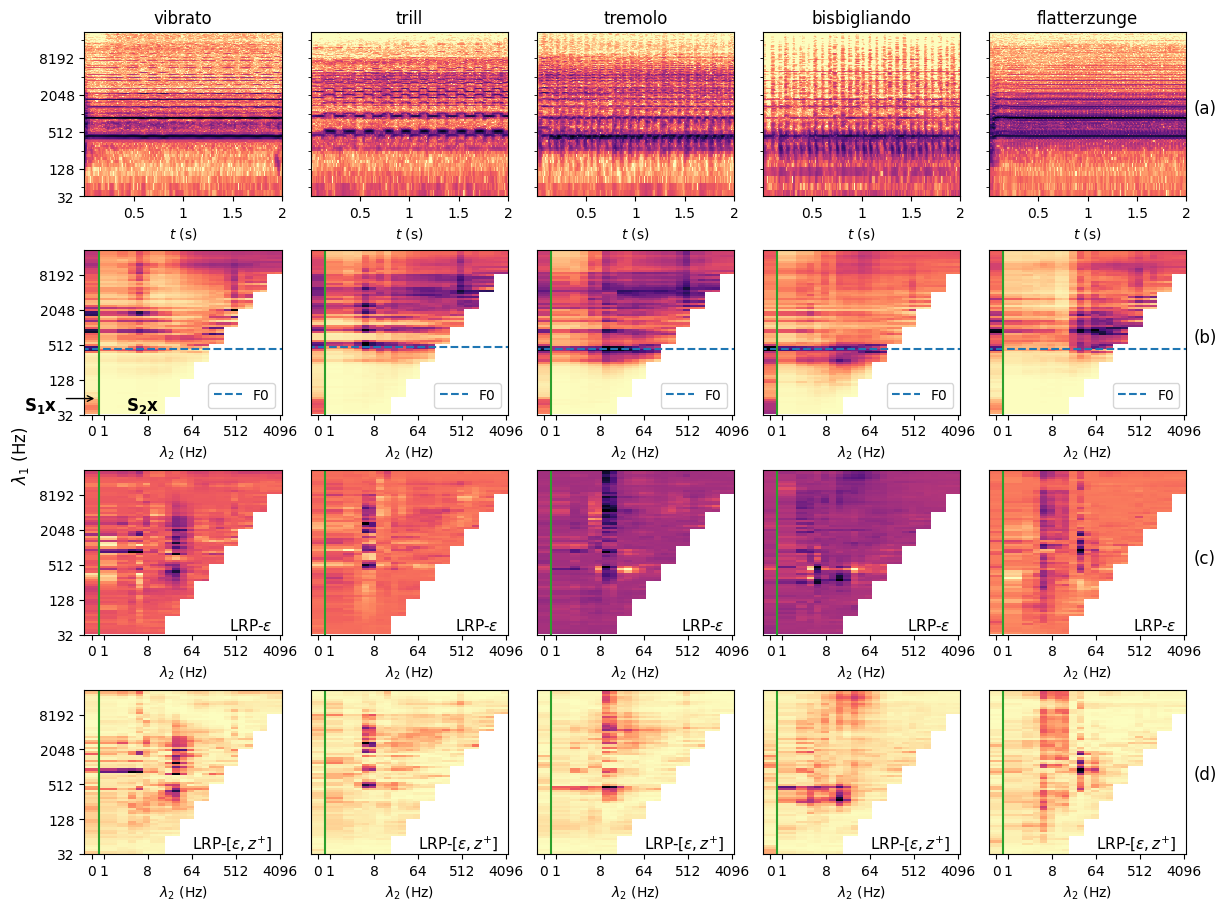

In [11]:
fig, axs = plt.subplots(4, 5, sharex=False, sharey=False, figsize=(12, 9))

test_examples = ['SOL-0.9HQ-PMT/scat1d/test/Bn-vib-A4-mf_S1S2.npy', 
                 'SOL-0.9HQ-PMT/scat1d/test/Vn-trill-maj2-A#4-mf-2c_S1S2.npy', 
                 'SOL-0.9HQ-PMT/scat1d/test/Vn+S-trem-A4-ff-4c_S1S2.npy', 
                 'SOL-0.9HQ-PMT/scat1d/test/Hp-bisb-A4-mf_S1S2.npy',
                 'SOL-0.9HQ-PMT/scat1d/test/Bn-flatt-A4-mf_S1S2.npy',
                 ]

for num in range(len(test_examples)):
    data, input_feature, class_name, target, note = input_per_file(test_examples[num])

    test_dir = '/home/changhongw/datasets/SOL-0.9HQ-PMT/'
    audio_name = os.path.split(test_examples[num])[-1][:-4].replace('_S1S2','')
    audio_file = glob.glob(test_dir + "**/**" + audio_name + ".wav", recursive = True)[0]

    # scalogram
    kx = 0; ky = num
    audio, sr = librosa.load(audio_file, sr=None)
    audio_full = normalize_audio(audio)
    audio = librosa.util.fix_length(audio_full, size=kwargs["shape"])
    D = librosa.stft(audio)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    specshow(S_db, x_axis='time', y_axis='log', cmap='magma_r', ax=axs[kx, ky], sr=sr)
    f0 = librosa.note_to_hz(note)
    axs[kx, ky].set_ylim(bottom=freq_min, top=max(y_coords))

    y_ticklabels = (lambda n: freq_min * 4 ** n)(np.arange(5))
    if num==0:
        axs[kx, ky].set_yticks(y_ticklabels)
        axs[kx, ky].set_yticklabels(y_ticklabels)
    else:
        axs[kx, ky].set_yticks([])
    axs[kx, ky].set_xticks([0.5, 1, 1.5, 2])
    axs[kx, ky].set_xticklabels([0.5, 1, 1.5, 2])
    axs[kx, ky].set_xlim([0, 2]) 
    axs[kx, ky].set(ylabel=None)
    axs[kx, ky].set(xlabel=r'$t$ (s)')
    axs[kx, ky].set_title(class_name)

    kx = 1; ky = num
    S_plot = specshow(
        input_feature, x_coords=x_coords, y_coords=y_coords,
        x_axis='cqt_hz', y_axis='cqt_hz', cmap='magma_r', ax=axs[kx, ky])
    f0 = librosa.note_to_hz(note)
    plt.plot(f0, color='green', linestyle='--')
    axs[kx, ky].plot([0.25*min(xi2s), max(xi2s)], [f0, f0], color='tab:blue', linestyle='--')
    axs[kx, ky].legend(['F0'], loc='lower right')
    axs[kx, ky].set_ylim(bottom=min(y_coords[y_coords >= freq_min]), top=max(y_coords))
    axs[kx, ky].axvline(x=x_coords[-2], color='tab:green')   
    axs[kx, ky].set(ylabel=None)
    axs[kx, ky].set(xlabel=r'$\lambda_2$ (Hz)')
    axs[kx, ky].set_ylim(bottom=freq_min, top=max(y_coords))
    if num==0:
        axs[kx, ky].set_yticks(y_ticklabels)
        axs[kx, ky].set_yticklabels(y_ticklabels)
    else:
        axs[kx, ky].set_yticks([])
    xpos_forS1 = np.sqrt(x_coords[-1] * x_coords[-2])
    max_xi2s = x_coords[np.where(np.isnan(input_feature[0,:]))[0][-1] + 1]
    axs[kx, ky].set_xlim(right=max_xi2s)
    x_ticklabels = list((lambda n: 8 ** n)(np.arange(5)))
    axs[kx, ky].set_xticks([xpos_forS1] + x_ticklabels)
    axs[kx, ky].set_xticklabels([0] + x_ticklabels)
    if num==0:
        axs[kx, ky].annotate('',
            xy=(0.055, 0.42), xycoords= S_plot,
            xytext=(-0.09, 0.42), textcoords= S_plot,
            arrowprops=dict(arrowstyle="->", # color='tab:green',
                            connectionstyle="arc3"),
            )
        
    figk = 2
    for composite in rule_types:
        # create the attributor, specifying model and composite
        with Gradient(model=model, composite=rule_types[composite]) as attributor:
            # compute the model output and attribution
            output, _ = attributor(data)
            pred = torch.zeros(len(class_map))
            pred[output.softmax(dim=-1).argmax(-1)] = 1               
            
            _ , attribution = attributor(data, pred)

        relevance_all = attribution.squeeze().mean(-1) 

        relevance_S2 = relevance_all[len(idx_S1):]
        
        # convert into list representation
        Sx2 = [{'coef': relevance_S2[k], 'n': meta['n'][idx_S2[k],:].astype(int)} for k in range(relevance_S2.shape[-1])]
        relevance = np.zeros((len(xi1s), 1+len(xi2s))) * np.nan

        relevance[:len(idx_S1), -1] = relevance_all[:len(idx_S1)]

        for path in Sx2:
            n1 = path['n'][0]
            xi1 = xi1s[n1]
            n2 = path['n'][1]
            xi2 = xi2s[n2]
            if xi1 * sr >= freq_min:
                relevance[n1, n2] = path['coef']

        # relevance = np.log1p(relevance / 1e-8)
        relevance[relevance==0] = np.nan

        kx = figk; ky = num 
        specshow(relevance, x_coords=x_coords, y_coords=y_coords,
            x_axis='cqt_hz', y_axis='cqt_hz', cmap='magma_r', ax=axs[kx, ky])
        axs[kx, ky].set_ylim(bottom=min(y_coords[y_coords >= freq_min]), top=max(y_coords))
        axs[kx, ky].axvline(x=x_coords[-2], color='tab:green')
        axs[kx, ky].set(ylabel=None)
        axs[kx, ky].set(xlabel=r'$\lambda_2$ (Hz)')
        axs[kx, ky].set_ylim(bottom=freq_min, top=max(y_coords))
        if num==0:
            axs[kx, ky].set_yticks(y_ticklabels)
            axs[kx, ky].set_yticklabels(y_ticklabels)
        else:
            axs[kx, ky].set_yticks([])
        axs[kx, ky].set_xlim(right=max_xi2s)
        axs[kx, ky].set_xticks([xpos_forS1] + x_ticklabels)
        axs[kx, ky].set_xticklabels([0] + x_ticklabels)

        rule_name = [r'LRP-$\epsilon$', r'LRP-$[\epsilon, z^{+}]$']
        axs[kx, ky].text(0.95, 0.01, rule_name[figk-2],
            verticalalignment='bottom', horizontalalignment='right',
            transform=axs[kx, ky].transAxes, fontsize=11)

        figk += 1
        del(relevance, Sx2)

fig.supylabel(r'$\lambda_1$ (Hz)')
fig.text(.99, .88, '(a)', fontsize=12, transform=fig.transFigure)
fig.text(.99, .625, '(b)', fontsize=12, transform=fig.transFigure)
fig.text(.99, .38, '(c)', fontsize=12, transform=fig.transFigure)
fig.text(.99, .14, '(d)', fontsize=12, transform=fig.transFigure)
fig.text(.015, .55, r'$\mathbf{S_{1}x}$', fontsize=12, transform=fig.transFigure)
fig.text(.1, .55, r'$\mathbf{S_{2}x}$', fontsize=12, transform=fig.transFigure)
# plt.savefig('results/local_maps.pdf',bbox_inches = "tight")
plt.savefig('results/local_maps.png', bbox_inches = "tight")

## kurtosis of test set using EpsilonPlus rule

In [12]:
relevance_obj = relevance_cal(
                test_dir='SOL-0.9HQ-PMT/scat1d/test/',
                rule_types=rule_types,
                model=model,
                class_abbrv=class_abbrv,
                )
relevance_obj.feature_relevance_all()

In [13]:
data = h5py.File('results/feature_relevance.hdf5', 'r')
def printname(name):
    print(name)
data.visit(printname)

composite_EpsilonPlus
composite_EpsilonPlus/bisbigliando
composite_EpsilonPlus/bisbigliando/feature
composite_EpsilonPlus/bisbigliando/relevance
composite_EpsilonPlus/flatterzunge
composite_EpsilonPlus/flatterzunge/feature
composite_EpsilonPlus/flatterzunge/relevance
composite_EpsilonPlus/tremolo
composite_EpsilonPlus/tremolo/feature
composite_EpsilonPlus/tremolo/relevance
composite_EpsilonPlus/trill
composite_EpsilonPlus/trill/feature
composite_EpsilonPlus/trill/relevance
composite_EpsilonPlus/vibrato
composite_EpsilonPlus/vibrato/feature
composite_EpsilonPlus/vibrato/relevance
single_Epsilon
single_Epsilon/bisbigliando
single_Epsilon/bisbigliando/feature
single_Epsilon/bisbigliando/relevance
single_Epsilon/flatterzunge
single_Epsilon/flatterzunge/feature
single_Epsilon/flatterzunge/relevance
single_Epsilon/tremolo
single_Epsilon/tremolo/feature
single_Epsilon/tremolo/relevance
single_Epsilon/trill
single_Epsilon/trill/feature
single_Epsilon/trill/relevance
single_Epsilon/vibrato
sing

In [14]:
kur_rulecmp = pd.DataFrame(columns=list(rule_types.keys()))

relevance_all = {rule:[] for rule in rule_types}
for rule in rule_types:
    for class_name in class_abbrv:
        relevance_class = np.array(data[rule][class_name]['relevance'])
        relevance_all[rule].append(np.mean(relevance_class, -1))

    relevance_all[rule] = np.vstack(np.array(relevance_all[rule]))
    kur_item = [kurtosis(item, fisher=True) for item in relevance_all[rule]]
    kur_rulecmp[rule] = kur_item

In [15]:
for rule in rule_types:
    print('Mean and std kurtosis on test set using {} rule:'.format(rule))
    print(np.round(kur_rulecmp[rule].mean(), 2), np.round(kur_rulecmp[rule].std(), 2))

Mean and std kurtosis on test set using single_Epsilon rule:
13.82 8.81
Mean and std kurtosis on test set using composite_EpsilonPlus rule:
19.22 13.72
